In [9]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import src.draw as plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Define

In [10]:
def metrics(data,attack_indx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    attack = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    attack[attack_indx] = 1
    pred[predict_index] = 1
    
    tp = np.sum((a == 1 and p == 1) for a, p in zip(attack, pred))
    fp = np.sum((a == 0 and p == 1) for a, p in zip(attack, pred))
    fn = np.sum((a == 1 and p == 0) for a, p in zip(attack, pred))
    tn = np.sum((a == 0 and p == 0) for a, p in zip(attack, pred))
    
    accuracy = (tp + tn) / len(attack)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy,precision,recall,f1

def rate_line_segments(line_segments,df):
    for line in line_segments:
        accuracy,precision,recall,f1 = metrics(df,attack_indx,anomaly_segment=line)
        if recall >=0.5 and precision >= 0.5:
            return line,accuracy,precision,recall,f1

In [11]:
def search_max_error(method,start,stop,df):
    '''
    Segmentation by 4 algorithms, 5 max_error
    
    Parameters
    ----------
    
    method : algorithms to segment ('Topdown','Btu','Sldw','SWAB')
    start : start range of max_error
    stop : end range of max_error
    df : a single df with 25 Product_type
    
    Returns
    -------
    
    list_maxerror : A list of 5 maxerrors
    list_detect : Include the detective of each Product_type per maxerror
    
    '''
    list_maxerror = []
    list_detect = []
    method_algorithms = {'Topdown':segment.topdownsegment,
                         'Btu':segment.bottomupsegment,
                         'Sldw': segment.slidingwindowsegment,
                         'SWAB': segment.SWABsegment}
    max_errors = np.linspace(start, stop, 5)
    
    for max_error in max_errors:
        list_p_type = np.zeros(25, dtype=int)
        for i in tqdm(range(25),desc=f'Max error: {max_error:.4f} loop'):
            try:
                ts_segments, line_segments = segment.get_ts_segments(method_algorithms[f'{method}'],list(df[i].values), fit.regression, 
                                                                     fit.sumsquared_error, max_error)
                line,accuracy,precision,recall,f1 = rate_line_segments(line_segments,df[i])
                list_p_type[i] = 1
            except:
                pass 
        if np.sum(list_p_type) != 0:
            list_maxerror.append(max_error)
            list_detect.append(list_p_type)
    if len(list_maxerror)==0:
        print(f'Cant detect')
        return 0,0
    for i in range(len(list_maxerror)):
        print(f'Max_error: {list_maxerror[i]:.3f} got {np.sum(list_detect[i])}/25 features detectable ')
    return list_maxerror,list_detect

In [12]:
def save_result(ID,method,list_maxerror,list_detect):
    '''
    Save result to flie Max_error_per_ID
    method: 'Topdown','Bottomup','Slidingwindow','SWAB'
    '''
    
    
    old_df = pd.read_csv('exp/Max_error_per_ID')

    new_df = pd.DataFrame({'ID':ID,'Algorithms':method,'Max_error':list_maxerror,'Detect':list_detect})
    new_df = pd.concat([new_df.drop(['Detect'], axis=1), new_df['Detect'].apply(pd.Series)], axis=1)
    new_columns = [f"P_type_{i+1}" for i in range(25)]
    new_df.columns = ['ID'] + ['Algorithms'] + ['Max_error'] + new_columns
    new_df['Total'] = new_df.iloc[:,3:].sum(axis=1)
    columns_order = ['ID','Algorithms','Max_error']

    df = pd.concat([old_df,new_df],ignore_index=True)
    df = df.drop_duplicates(subset=columns_order)
    df.to_csv('exp/Max_error_per_ID',index=False)
    display(df)

In [13]:
label_df = pd.read_csv('data/labeled_anomalies.csv')
label_df['anomaly_sequences'] = label_df['anomaly_sequences'].apply(lambda x: np.array(eval(x)))

In [14]:
np.sort( label_df[label_df['spacecraft']=='SMAP']['chan_id'].unique())

array(['A-1', 'A-2', 'A-3', 'A-4', 'A-5', 'A-6', 'A-7', 'A-8', 'A-9',
       'B-1', 'D-1', 'D-11', 'D-12', 'D-13', 'D-2', 'D-3', 'D-4', 'D-5',
       'D-6', 'D-7', 'D-8', 'D-9', 'E-1', 'E-10', 'E-11', 'E-12', 'E-13',
       'E-2', 'E-3', 'E-4', 'E-5', 'E-6', 'E-7', 'E-8', 'E-9', 'F-1',
       'F-2', 'F-3', 'G-1', 'G-2', 'G-3', 'G-4', 'G-6', 'G-7', 'P-1',
       'P-2', 'P-3', 'P-4', 'P-7', 'R-1', 'S-1', 'T-1', 'T-2', 'T-3'],
      dtype=object)

## F_1

In [7]:
anomaly_index = label_df[label_df['chan_id']=='F-1']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

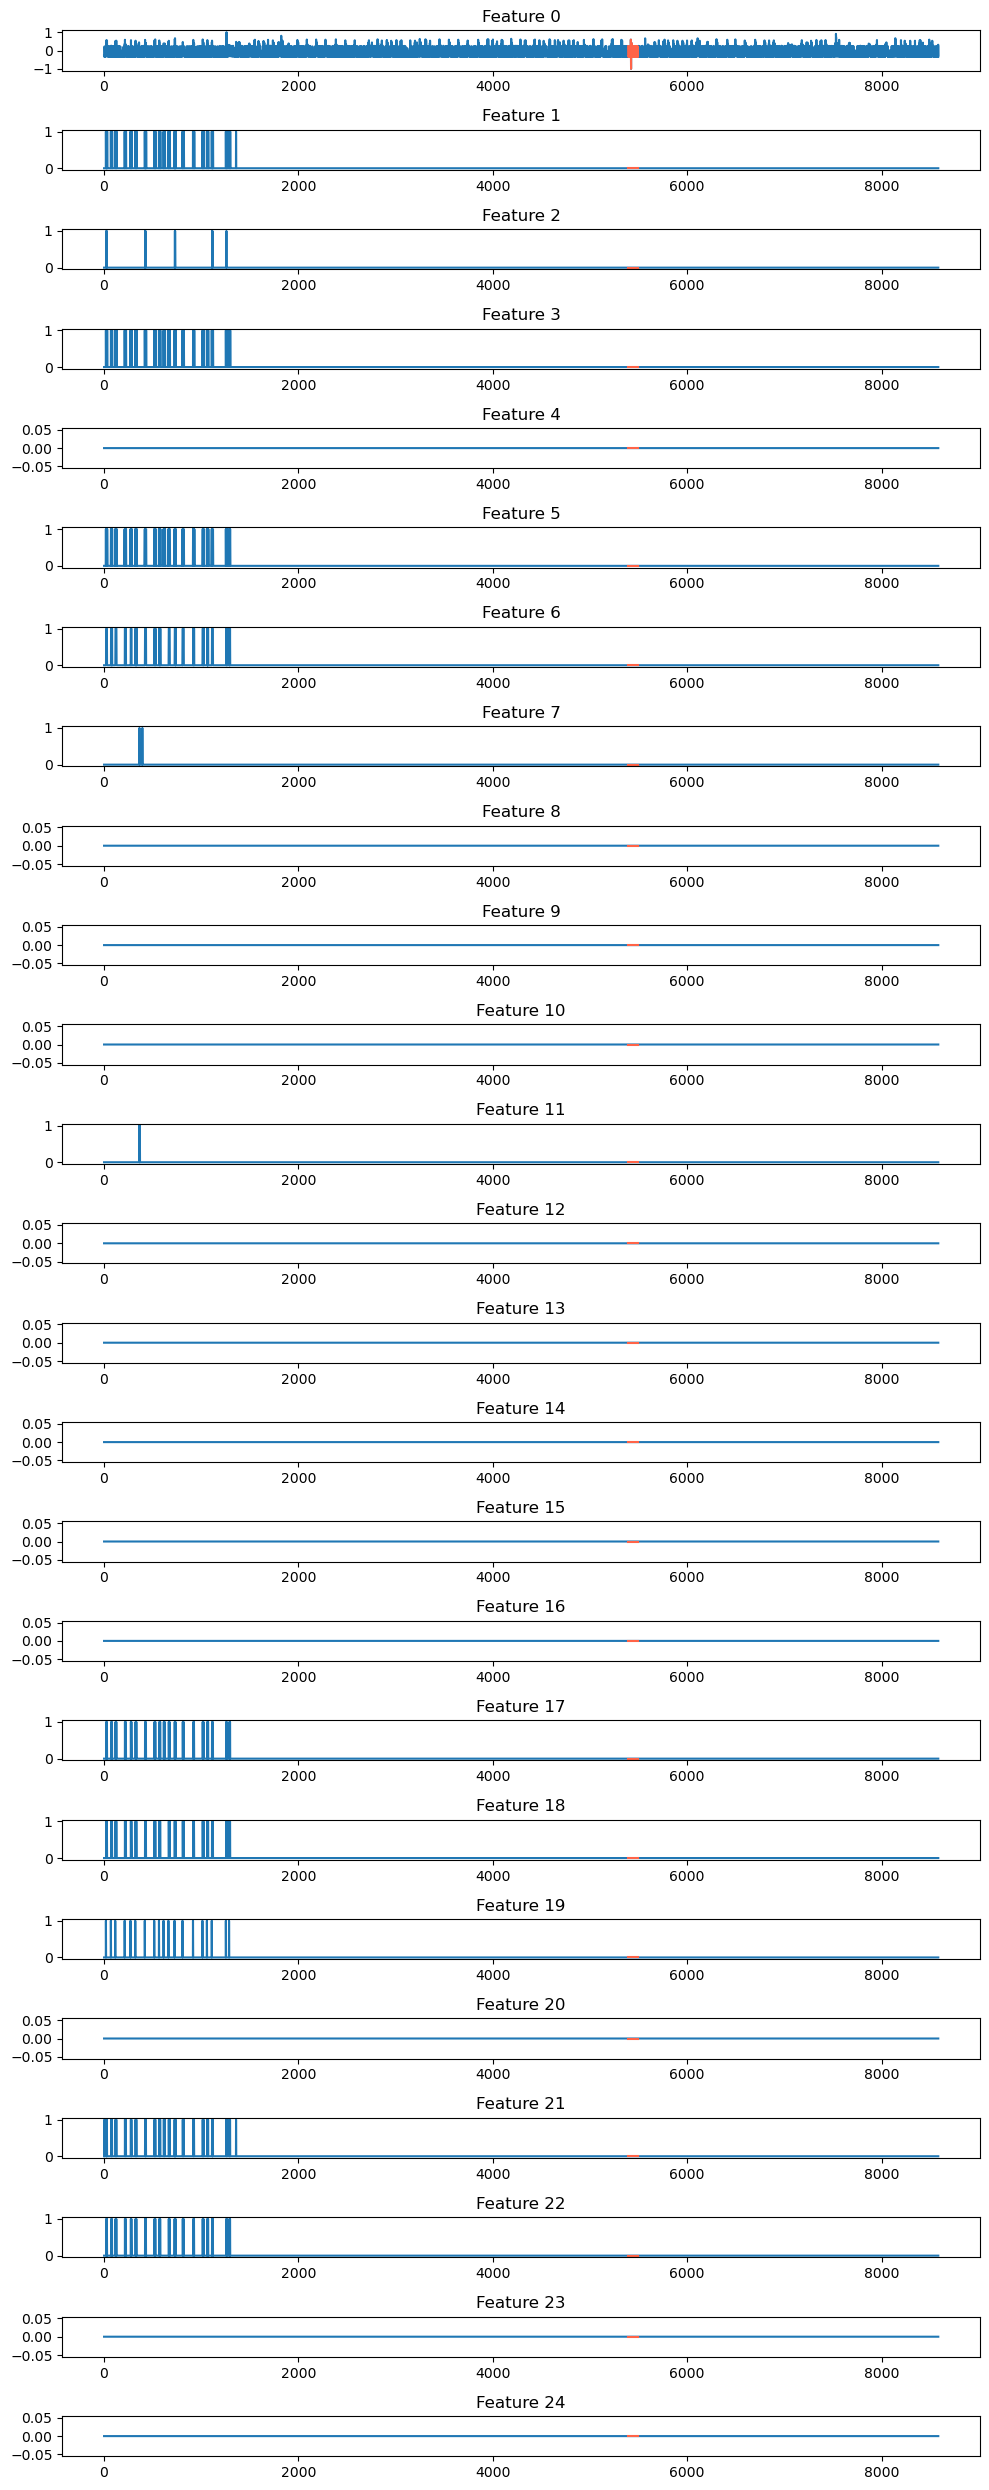

In [8]:
data = np.load('data/test/F-1.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='F-1']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

In [9]:
ID = 'F_1'

**Topdown**

In [10]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [05:41<00:00, 13.67s/it]

Max_error: 3.250 got 1/25 features detectable 


In [11]:
save_result(ID,'Topdown',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,E_5,SWAB,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
177,E_6,Slidingwindow,3.25,0,1,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,5
178,E_6,Slidingwindow,5.50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
179,E_6,Slidingwindow,7.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


**Slidingwindow**

In [12]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:17<00:00,  3.12s/it]

Max_error: 3.250 got 1/25 features detectable 


In [13]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,E_6,Slidingwindow,3.25,0,1,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,5
178,E_6,Slidingwindow,5.50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
179,E_6,Slidingwindow,7.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
180,F_1,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**SWAB**

In [14]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.49s/it]

Max_error: 3.250 got 1/25 features detectable 
Max_error: 5.500 got 1/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 


In [16]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,F_1,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
181,F_1,Slidingwindow,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
182,F_1,SWAB,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
183,F_1,SWAB,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Btu**

In [10]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.58s/it]

Cant detect


In [11]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [9]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='F_1']

ERROR! Session/line number was not unique in database. History logging moved to new session 644


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
180,F_1,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
181,F_1,Slidingwindow,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
182,F_1,SWAB,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
183,F_1,SWAB,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
184,F_1,SWAB,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## F_2

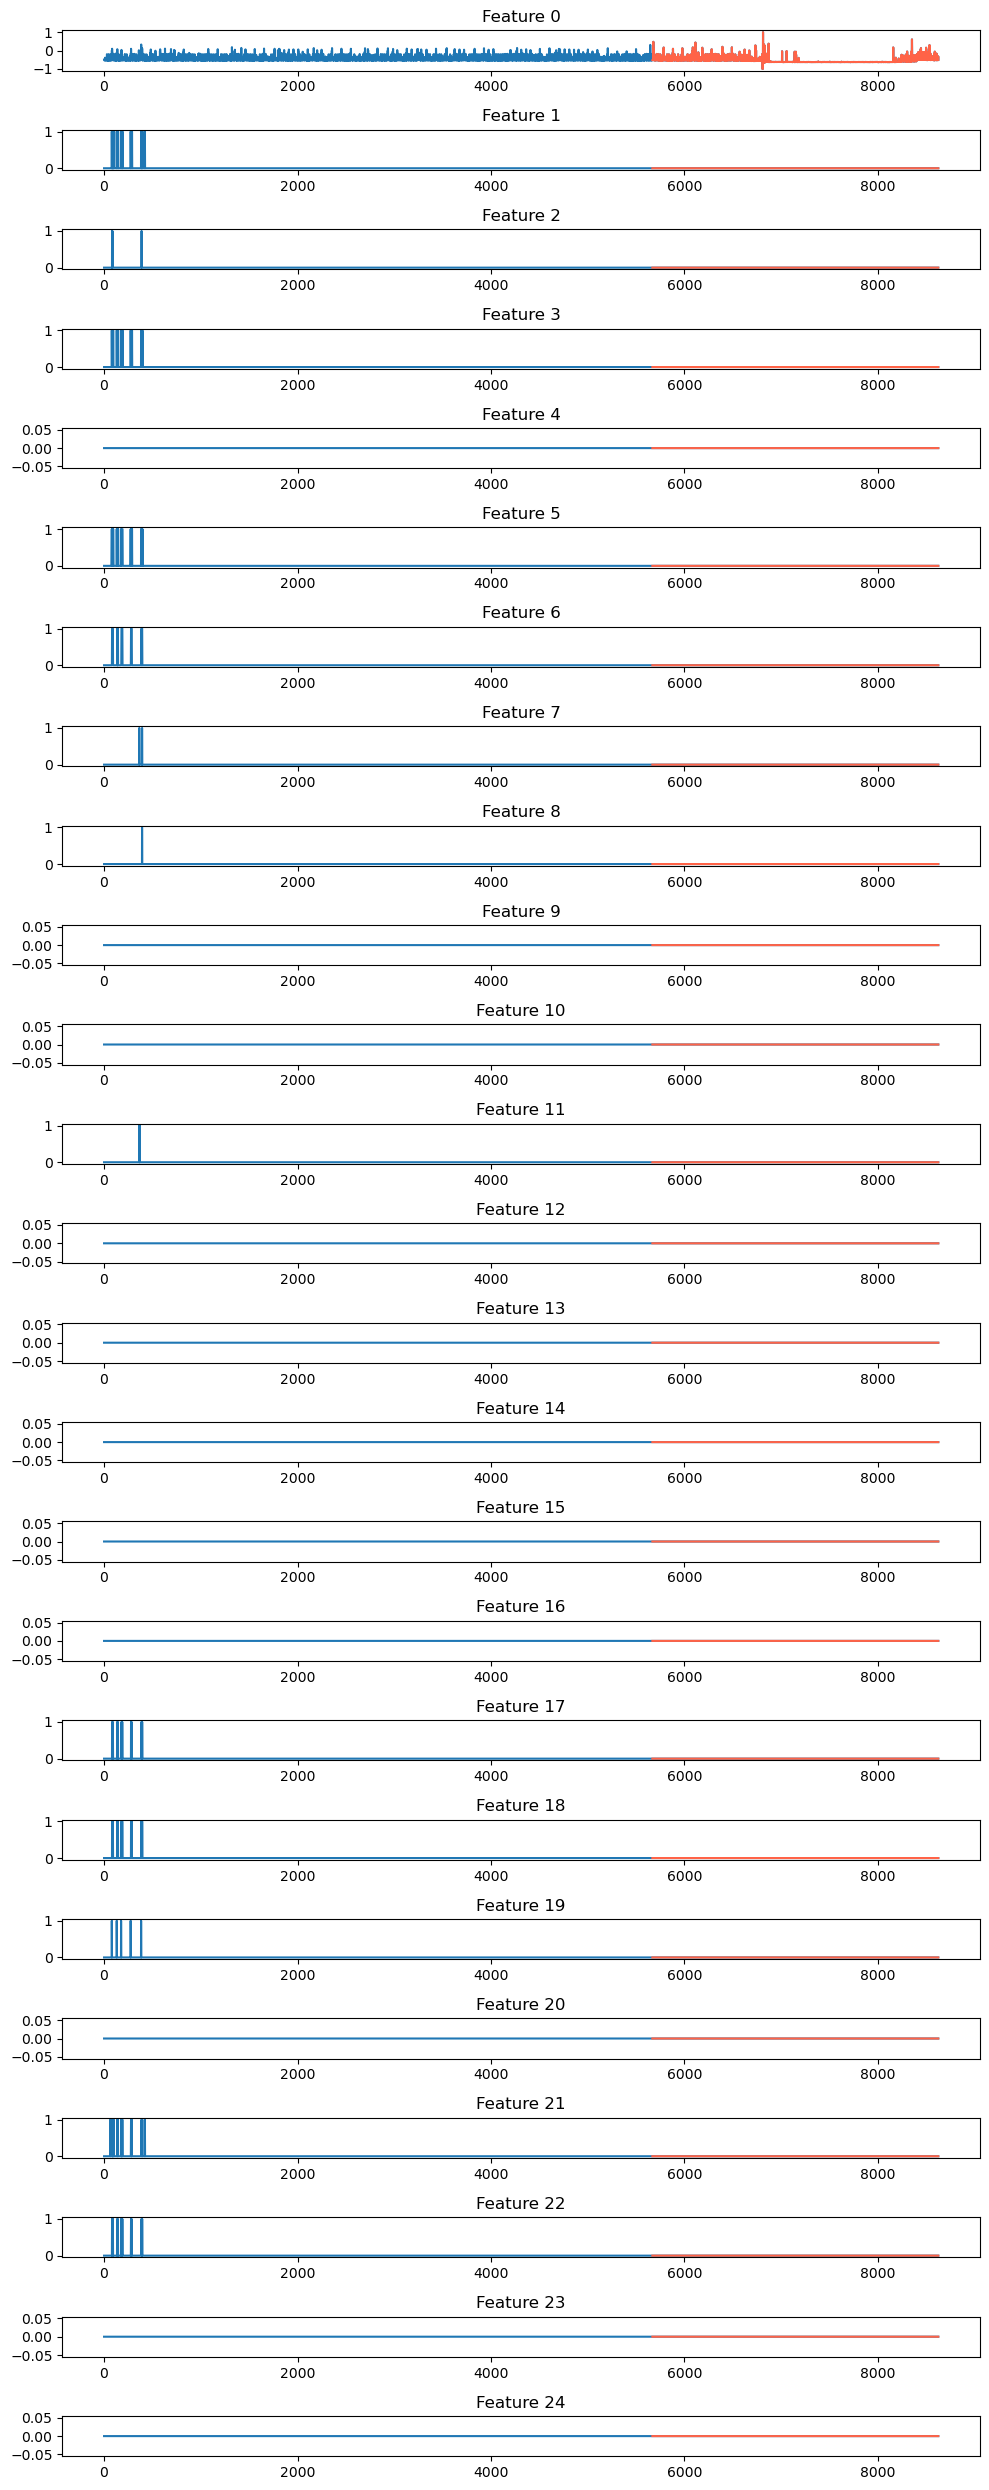

In [7]:
anomaly_index = label_df[label_df['chan_id']=='F-2']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/F-2.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='F-2']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'F_2'

In [14]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [10:59<00:00, 26.38s/it]

Cant detect


In [17]:
def run_all_and_save(ID,start=1,stop=10):
    method_dict = {'Topdown':'Topdown','Btu':'Bottomup','Sldw':'Slidingwindow','SWAB':'SWAB'}
    for key,val in method_dict.items():
        list_maxerror,list_detect = search_max_error(method=key,start=start,stop=stop,df=df)
        try:
            save_result(ID,val,list_maxerror,list_detect)
        except:
            print(f'Cant save  NoneType at {val}')

In [ ]:
run_all_and_save(ID,start=0.01,stop=0.5)

Max error: 0.5000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [08:18<00:00, 19.95s/it]


Cant detect
Cant save  NoneType at Topdown


Max error: 0.5000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [04:08<00:00,  9.96s/it]


Cant detect
Cant save  NoneType at Bottomup


Max error: 0.5000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [02:05<00:00,  5.02s/it]


Cant detect
Cant save  NoneType at Slidingwindow


Max error: 0.5000 loop:  12%|███████                                                    | 3/25 [02:06<12:05, 32.97s/it]

In [ ]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=0.01,stop=0.5,df=df)

Max error: 0.5000 loop:  68%|█████████████████████████████████████▍                 | 17/25 [1:49:27<26:08, 196.08s/it]

In [ ]:
save_result(ID,'SWAB',list_maxerror,list_detect)

# F_3

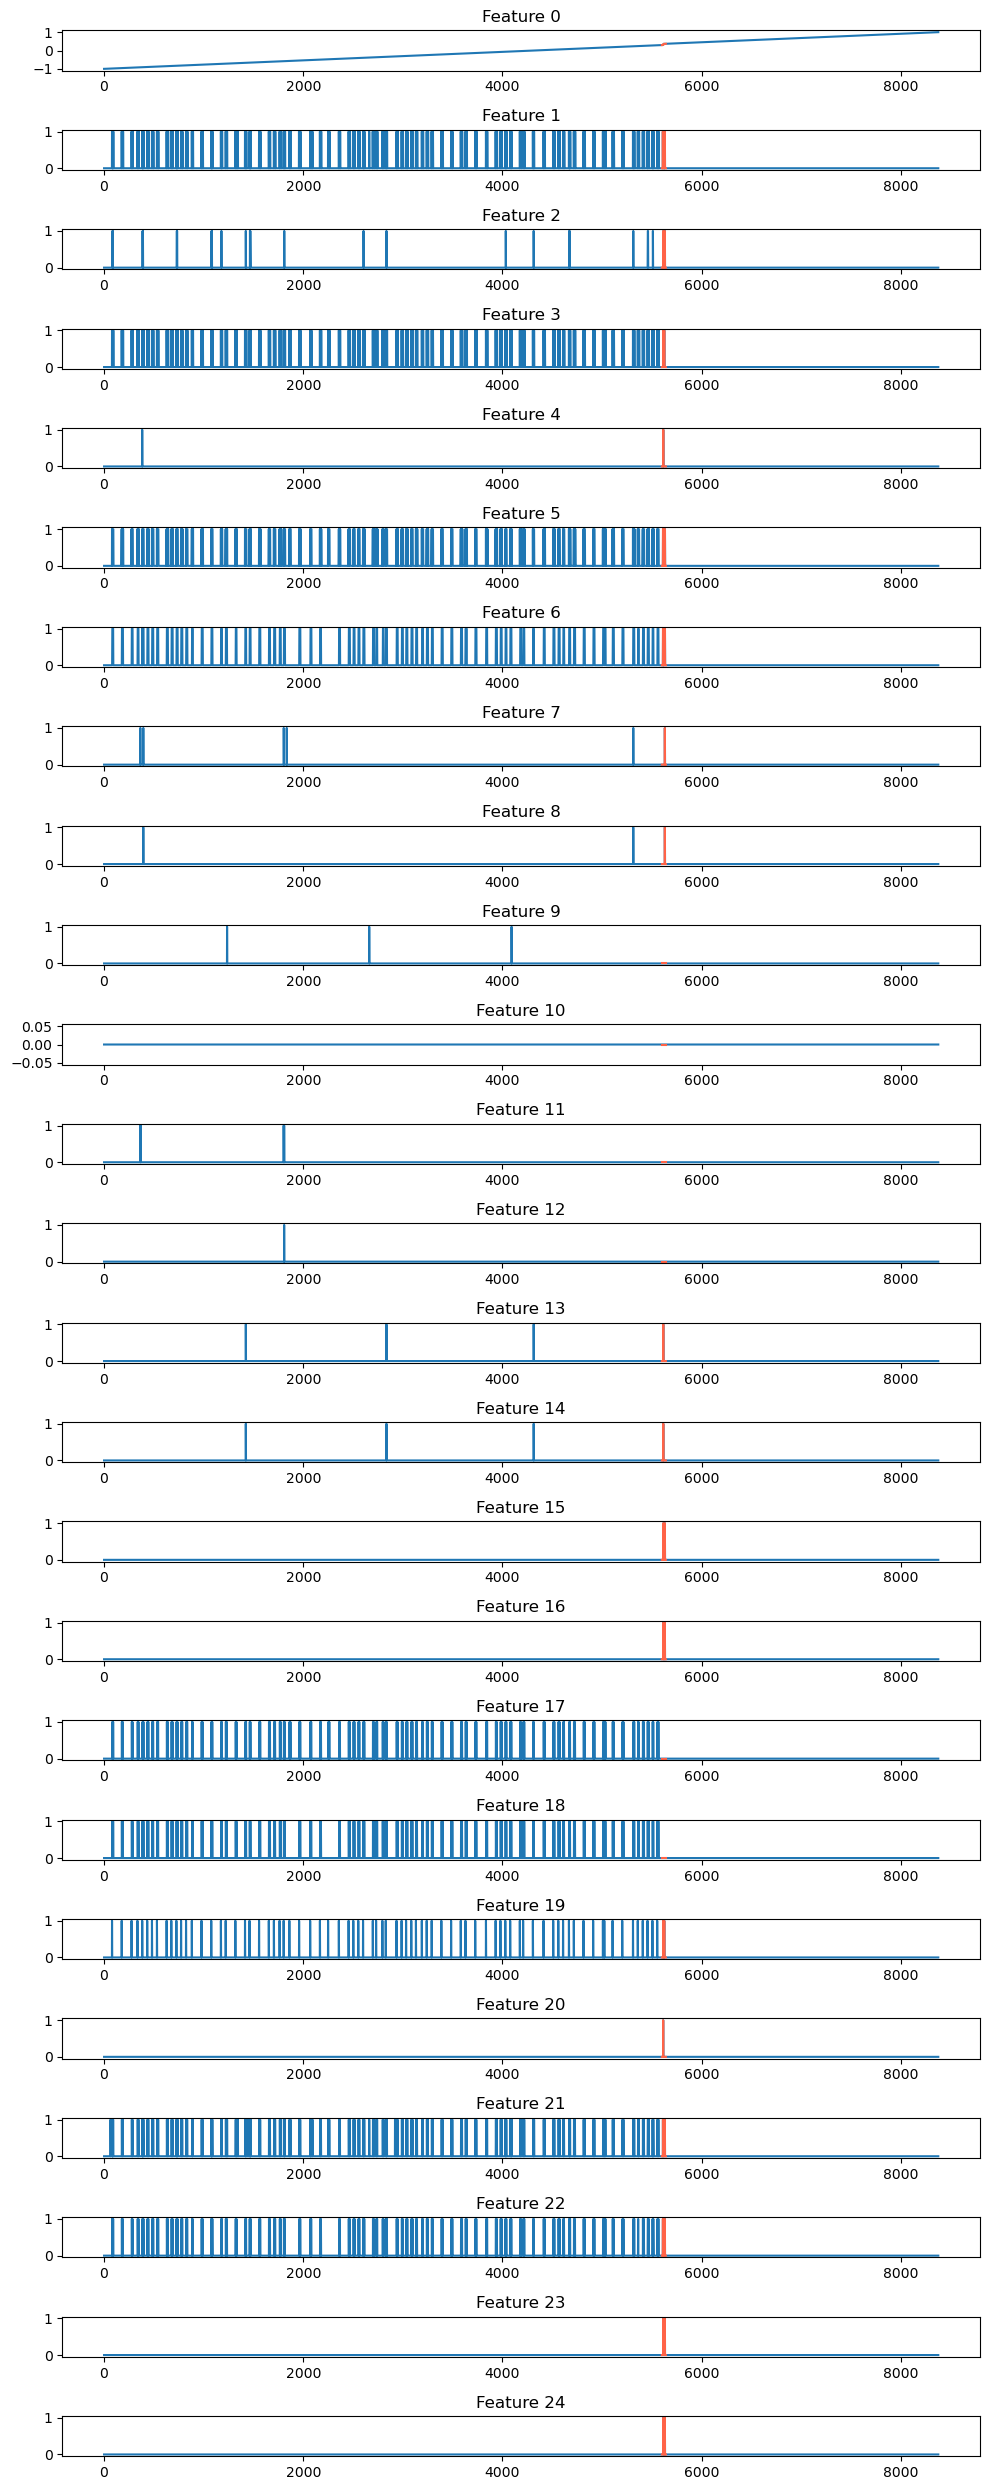

In [15]:
anomaly_index = label_df[label_df['chan_id']=='F-3']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/F-3.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='F-3']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'F_3'

In [18]:
run_all_and_save(ID,start=1,stop=10)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [10:48<00:00, 25.95s/it]

Max_error: 5.500 got 2/25 features detectable 
Max_error: 7.750 got 4/25 features detectable 
Max_error: 10.000 got 4/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,F_1,SWAB,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
184,F_1,SWAB,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
185,F_3,Topdown,5.50,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
186,F_3,Topdown,7.75,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,4


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:39<00:00,  3.96s/it]


Cant detect
Cant save  NoneType at Bottomup


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:05<00:00,  2.60s/it]

Max_error: 3.250 got 1/25 features detectable 
Max_error: 5.500 got 2/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,F_3,Topdown,7.75,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,4
187,F_3,Topdown,10.00,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,4
188,F_3,Slidingwindow,3.25,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
189,F_3,Slidingwindow,5.50,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,2


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [03:10<00:00,  7.61s/it]

Cant detect
Cant save  NoneType at SWAB


In [19]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='F_3']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
185,F_3,Topdown,5.50,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
186,F_3,Topdown,7.75,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,4
187,F_3,Topdown,10.00,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,4
188,F_3,Slidingwindow,3.25,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
189,F_3,Slidingwindow,5.50,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,2
190,F_3,Slidingwindow,7.75,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
